In [ ]:
%pip install nltk
%pip install tweepy
%pip install pandas
%pip install wordcloud
%pip install textblob
%pip install seaborn
%pip install tensorflow
%pip install sklearn
%pip install zemberek-python
%pip install trnltk
%pip install git+https://github.com/emres/turkish-deasciifier.git
%pip install transformers datasets
%pip install torch
%pip install tensorflow
%pip install pyautogui
%pip install snowballstemmer
%pip install vaderSentiment

In [ ]:
#!/usr/bin/env python
#-*-coding:utf-8-*-
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)
import pyautogui
import tweepy
import csv
import sys
import time
import re
from tqdm import tqdm
import warnings
import string
import pandas as pd
import ast
import nltk
from snowballstemmer import TurkishStemmer as snowTurkish
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as st
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from tweepy import Stream ,OAuthHandler
from tweepy.streaming import Stream
from wordcloud import WordCloud
from textblob import TextBlob
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from trnlp import TrnlpWord
from trnlp import *
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    TextClassificationPipeline, 
    pipeline, 
    AutoModelWithLMHead,
    AutoModel,
    ElectraTokenizer, 
    TFElectraForMultipleChoice,
    TFElectraForSequenceClassification
    )
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [122]:
class getTweets:
    
    def __init__(self,ckey,csecret,atoken,asecret):
        self.api=None
        self.consumer_key = ckey
        self.consumer_secret = csecret
        self.access_token = atoken
        self.access_token_secret = asecret
        
    def setAuth(self):
        try:
            self.auth = tweepy.OAuthHandler(self.consumer_key, self.consumer_secret)
            self.auth.set_access_token(self.access_token, self.access_token_secret)
            self.api = tweepy.API(self.auth)            
            print ("Bağlantı Yapıldı!")                           
        except tweepy.TweepError as err:
            print('Error: {}'.format(err))   
    
    def toDataFrame(tweets):
        try:
            print ("Veriler Kayıt Ediliyor...")
            pd.set_option('display.max_rows', None)
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            pd.set_option('display.max_colwidth', None)
            DataSet = pd.DataFrame()
            
            DataSet['Kullanıcı_Adı'] = [tweet.user.name for tweet in tweets]
            DataSet['Tweet_Tarih'] = [tweet.created_at for tweet in tweets]   
            #DataSet['Tweet_Id'] = [tweet.id for tweet in tweets]
            DataSet['Tweet'] = [tweet.full_text for tweet in tweets]
            #DataSet['Tweet_Degistirilmis'] = [tweet.full_text for tweet in tweets]
            #DataSet['Tweet_Ceviri']=[tweet.full_text for tweet in tweets]            
            #DataSet['Kullanıcı_Id'] = [tweet.user.id for tweet in tweets]  
                
            #DataSet['Dil'] = [tweet.lang for tweet in tweets]
            DataSet.to_csv('Datasets/tw.csv',index=False)
            print ("Veriler Kayıt Edildi!")
            return DataSet
        except Exception as err:
            print('Error: {}'.format(err))
    
    def searchTweet(self,arananTweet):
        self.setAuth()
        try:                      
            print ("Kelimeye Uygun Tweetler Sorgulanıyor...")
            cursor = tweepy.Cursor(self.api.search_tweets, q=arananTweet,result_type="new", lang='tr',tweet_mode="extended")
            results=[]
            for item in cursor.items(150):
                results.append(item)
            print ("Kelimeye Uygun Tweetler Sorgulandı!")
            DataSet = getTweets.toDataFrame(results)            
        except Exception as err:
            print('Error: {}'.format(err))
        finally:
            Dataset=pd.read_csv('Datasets/tw.csv',encoding="utf-8")                   
            getTweets.TweetClear(DataSet)#Tweet Temizlemek için
            getTweets.SentenceNormalization(DataSet)#Türkçe hatalı yazılmış kelimeleri düzeltmek için
            getTweets.TweetTranslate(DataSet)#Tweetleri İngilizceye çevirmek için
            getTweets.EngWordSeparation(DataSet)#İngilizce kelime Stopwords 
            getTweets.TrWordSeparation(DataSet)#Türkçe kelime Stopwords
            getTweets.ToxicSentence(DataSet)#İngilizce Argo cümle bulmak için             
            getTweets.TrStemmed(DataSet)#Türkçe Kelime köklerini almak için
            getTweets.EngStemmed(DataSet)#İngilizce Kelime köklerini almak için
            getTweets.TextblobSentiment(DataSet)#Textblob Duygu Analizi (Kelime pozitif negatif olarak sorguluyor)           
            DataSet.to_csv('Datasets/tw.csv',index=False)

    def TextblobSentiment(DataSet):
        try:
            data=DataSet
            print ("Duygu Analizi Yapılıyor...")            
            data["TextBlobTür"] = data["Tweet_Ayrı_Eng"].apply(getTweets.getPolarity)
            data["TextBlobYoğunluk"] = data["Tweet_Ayrı_Eng"].apply(getTweets.getSubjectivity)
            data.to_csv('Datasets/textblob_eng_duygu.csv',index=False)
            print("Duygu Analizi Yapıldı!")                        
        except Exception as err:
            print('Error: {}'.format(err)) 
            
    def TweetClear(DataSet):
        try:
            data=DataSet
            print ("Tweetler Temizleniyor...")
            data["Tweet_Clear"]=data["Tweet"]
            pattern = re.compile('http[s]?://(?:[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+|#[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]+|$[a-zA-ZğüşöçıİĞÜŞÖÇ]+|@[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ_]+|[,.^_$*%-;鶯!?’"“”:=|…#]+|\n+|amp[\s]+|gt;')
            for index in range(len(data["Tweet_Clear"])):        
                data["Tweet_Clear"][index]=pattern.sub(' ', data["Tweet_Clear"][index])    
                data["Tweet_Clear"][index]=data["Tweet_Clear"][index].lower()              
            data["Tweet_Clear"]=data["Tweet_Clear"].str.replace("[^\w\s]","")
            print ("Tweetler Temizlendi!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))  
                              
    def TweetTranslate(DataSet):
        try:
            data=DataSet
            print ("Tweetler Çeviriliyor...")
            data["Tweet_Eng"]=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Eng"])):
                Ceviri_Blob=TextBlob(data["Tweet_Eng"][index])
                Eng_Blob=Ceviri_Blob.translate(from_lang='tr', to='en')  
                data["Tweet_Eng"][index]=Eng_Blob  
                data["Tweet_Eng"][index]=data["Tweet_Eng"][index].lower()
            print ("Tweetler Çevirildi!")                      
            return data      
        except Exception as err:
            print('Error: {}'.format(err)) 
            
    def SentenceNormalization(DataSet):
        try:
            data=DataSet
            print("Cümle Normalizasyonu Yapılıyor...")
            morphology = TurkishMorphology.create_with_defaults()
            normalizer = TurkishSentenceNormalizer(morphology)
            for index in range(len(data["Tweet_Clear"])):                
                data["Tweet_Clear"][index]= normalizer.normalize(data["Tweet_Clear"][index].lower())
            print("Cümle Normalizasyonu Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def TrWordSeparation(DataSet):
        try:
            data=DataSet
            print("Türkçe Kelime Ayrıştırma Yapılıyor...")
            data["Tweet_Ayrı_TR"]=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Ayrı_TR"])):
                data["Tweet_Ayrı_TR"][index] = simple_token(data["Tweet_Ayrı_TR"][index], sw=stopwords)
            data["Tweet_Ayrı_TR"] = data["Tweet_Ayrı_TR"].str.join(" ")
            print("Türkçe Kelime Ayrıştırma Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))  
                  
    def EngWordSeparation(DataSet):
        try:
            data=DataSet
            print("İngilizce Kelime Ayrıştırma Yapılıyor...")
            additional  = ['sq','gt','mk','aq','qq','amk']
            stop = st.words('english')
            
            data["Tweet_Ayrı_Eng"] = data["Tweet_Eng"].str.split()           
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].apply(lambda x: [item for item in x if item not in stop])
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].apply(lambda x: [item for item in x if item not in additional])
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].str.join(" ")
            print("İngilizce Kelime Ayrıştırma Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def TrStemmed(DataSet):
        try:
            data=DataSet
            data["TR_Kök"] = data["Tweet_Ayrı_TR"]
            # Kök Bulma
            stemmer = snowTurkish()

            stemmed_lists = []
            for index in tqdm(data["TR_Kök"].index):
                mini_l = []
                for text in data.loc[index]["TR_Kök"].split(" "):
                    mini_l.append(stemmer.stemWord(text))

                big_text=" "
                for char in mini_l:
                    big_text = big_text + " " + char
                stemmed_lists.append(big_text)
    
            DataSet['TR_Kök'] = stemmed_lists
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def EngStemmed(DataSet):
        try:
            data=DataSet
            data["Eng_Kök"] = data["Tweet_Ayrı_Eng"]
            # Kök Bulma
            stemmer = PorterStemmer()

            stemmed_lists = []
            for index in tqdm(data["Eng_Kök"].index):
                mini_l = []
                for text in data.loc[index]["Eng_Kök"].split(" "):
                    mini_l.append(stemmer.stem(text))

                big_text=" "
                for char in mini_l:
                    big_text = big_text + " " + char
                stemmed_lists.append(big_text)
    
            DataSet['Eng_Kök'] = stemmed_lists
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def ToxicSentence(DataSet):
        try:
            data=DataSet
            print("Toxic Cümle Analizi Yapılıyor...")
            model_path ="martin-ha/toxic-comment-model"
            tokenizer=AutoTokenizer.from_pretrained(model_path)
            model=AutoModelForSequenceClassification.from_pretrained(model_path)
            pipeline=TextClassificationPipeline(model=model, tokenizer=tokenizer)
            data["Tweet_Toxic"]=data["Tweet_Eng"]
            temp=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Toxic"])):
                sonuc=pipeline(str(data["Tweet_Toxic"][index]))
                if sonuc[0]['label']=="toxic":
                    data["Tweet_Toxic"][index]="Toxic"
                else:
                    data["Tweet_Toxic"][index]="Toxic değil"    
            print("Toxic Cümle Analizi Yapıldı!")
            return data  
        except Exception as err:
            print('Error: {}'.format(err))
        
    def getSubjectivity(DataSet):
        try: 
            sub=TextBlob(DataSet).sentiment.subjectivity               
            if sub >=0.75:
                return "%75 - %100"
            elif sub >=0.5 and sub <0.75:
                return "%50 - %75"
            elif sub >=0.25 and sub <0.50:
                return "%25 - %50"
            else:
                return "0 - 25%"
        except Exception as err:
            print('Error: {}'.format(err))
            
    def getPolarity(DataSet):
        try:
            pol=TextBlob(DataSet).sentiment.polarity
            if pol>0.1:
                return "Pozitif"
            elif pol<-0.1:
                return "Negatif"
            else:
                return "Nötr"
        except Exception as err:
            print('Error: {}'.format(err))

In [123]:
tw = getTweets( 
ckey = 'o7qidRODRWm5u07PtAWrCpSqf',
csecret = '1Yn60OYMJl5kRCSM0XQ4Lskxh6hjM4VMz51OdsS6dM9DQuQ4MV',
atoken = '1315792402234441730-Dt7AydgVGYI5VN9RRQfnR8Endh0WAc',
asecret = 'jhfiDfB53Z27EqHfvfKbNdo0w2SWLqyyoAkILqgSoaGMK'
)
while True:
    aramaTuru=pyautogui.confirm('Ne Tür Bir Arama Yapacaksınız?',title='Arama Türü', buttons=['Hastag','Kelime','Kullanıcı'])
    if aramaTuru=="Hastag":
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=("#"+arananKelime+" -filter:retweets")
        tw.searchTweet(arananTweet=temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    elif aramaTuru=='Kelime':
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=(arananKelime+" -filter:retweets")
        tw.searchTweet(arananTweet=temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    elif aramaTuru=='Kullanıcı':
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=("@"+arananKelime+" -filter:retweets")
        tw.searchTweet(temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    else:
        secim=pyautogui.confirm(text='Hatalı Seçim Yaptınız Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","Kapat"])
        if secim=="Tekrar":
            continue
        else:
            break


Bağlantı Yapıldı!
Kelimeye Uygun Tweetler Sorgulanıyor...
Kelimeye Uygun Tweetler Sorgulandı!
Veriler Kayıt Ediliyor...
Veriler Kayıt Edildi!
Tweetler Temizleniyor...
Tweetler Temizlendi!
Cümle Normalizasyonu Yapılıyor...
2023-01-16 19:28:08,451 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 8.967018365859985

Cümle Normalizasyonu Yapıldı!
Tweetler Çeviriliyor...
Tweetler Çevirildi!
İngilizce Kelime Ayrıştırma Yapılıyor...
İngilizce Kelime Ayrıştırma Yapıldı!
Türkçe Kelime Ayrıştırma Yapılıyor...
Türkçe Kelime Ayrıştırma Yapıldı!
Toxic Cümle Analizi Yapılıyor...
Toxic Cümle Analizi Yapıldı!


100%|██████████| 150/150 [00:00<00:00, 4166.61it/s]


Duygu Analizi Yapılıyor...
Duygu Analizi Yapıldı!


### OLUŞTURDUĞUMUZ TWİTTER VERİSETİ

In [141]:
Data=pd.read_csv('Datasets/textblob_eng_duygu.csv')
Data.head()

,Kullanıcı_Adı,Tweet_Tarih,Tweet,Tweet_Clear,Tweet_Eng,Tweet_Ayrı_Eng,Tweet_Ayrı_TR,Tweet_Toxic,TR_Kök,Eng_Kök,Tür,Yoğunluk
0,Fatih.Atar,2023-01-16 16:27:38+00:00,"Düşün şimdi: Tüm siyasi gündemi takip ediyorsun,futbol bilgin çok iyi. Borsadaki gelişmeler senden soruluyor. İşinde çok iyisin. Sosyal hayatın çok dolu. Dini meselelere bir türlü vakit bulamıyorsun. Sonra bir trafik kazası hoop ahirettesin. Ve hiçbir ilgin ve bilgin olmayan 👇",düşün şimdi tüm siyasi gündemi takip ediyorsun futbol bilgin çok iyi borsadaki gelişmeler senden soruluyor işinde çok iyisin sosyal hayatın çok dolu dini meselelere bir türlü vakit bulamıyorsun sonra bir trafik kazası hoop ahirettesin ve hiçbir ilgin ve bilgin olmayan,"think now you are following all the political agenda football bilgin very good stock market developments are being asked from you very good in your business, you can not find a time for a very full religious issues of social life, then a traffic accident is in the hereafter and no interest and no knowledge","think following political agenda football bilgin good stock market developments asked good business, find time full religious issues social life, traffic accident hereafter interest knowledge",düşün siyasi gündemi takip ediyorsun futbol bilgin iyi borsadaki gelişmeler soruluyor işinde iyisin sosyal hayatın dolu dini meselelere türlü vakit bulamıyorsun trafik kazası hoop ahirettesin hiçbir ilgin bilgin olmayan,Toxic değil,düş siyas günde takip ediyor futbol bilgi i borsa gelişme soruluyor iş i sosyal hayat dol t mesele türlü vakit bulamıyor trafik kazas hoop ahiret hiçbir ilgi bilgi olmaya,"think follow polit agenda footbal bilgin good stock market develop ask good business, find time full religi issu social life, traffic accid hereaft interest knowledg",Pozitif,%25 - %50
1,Eymen Çopur,2023-01-16 16:27:14+00:00,Ahh sıradaki futbol maçı ne zaman ne zaman? Şu kareler bile kalbini alıp götürüyor insanın. Karşıyaka Spor Kulübünün hastasıyız https://t.co/Y6qTpOyw0c,aah sıradaki futbol maçı ne zaman ne zaman şu kareler bile kalbini alıp götürüyor insanın karşıyaka spor kulübünün hastasıyız,"aah, the next football match when when even those squares take away the heart of the people of the people of karşıyaka sports club","aah, next football match even squares take away heart people people karşıyaka sports club",aah sıradaki futbol maçı zaman zaman kareler kalbini alıp götürüyor insanın karşıyaka spor kulübünün hastasıyız,Toxic değil,aah sıra futbol maç zama zama kare kalp alıp götürüyor insa karşıyak spor kulüp hastas,"aah, next footbal match even squar take away heart peopl peopl karşıyaka sport club",Nötr,0 - 25%
2,Okan Ç.,2023-01-16 16:27:05+00:00,"Milli Mücadele döneminde kurulduğu günden bu yana ilke ve kültürünü asla kaybetmeyen, her daim bilim,ahlak,felsefe şartlarıyla aydınlanmayı benimseyen, endüstriyel futbol dünyasında yerini alınmadan-satılmadan korumuş bir değer.\niyi ki doğdun soylu kavgam. \n#BüyükAltay109Yaşında",milli mücadele döneminde kurulduğu günden bu yana ilke ve kültürünü asla kaybetmeyen her daim bilim ahlak felsefe şartlarıyla aydınlanmayı benimseyen endüstriyel futbol dünyasında yerini alınmadan satılmadan korumuş bir değer iyi ki doğdun soylu kavgam,"since the day it was founded during the national struggle period, the principle and culture that has never lost its culture with the conditions of science, which has adopted the enlightenment with the conditions of moral philosophy, a value that has protected it without being sold in the world of football, is good that you were born.","since day founded national struggle period, principle culture never lost culture conditions science, adopted enlightenment conditions moral philosophy, value protected without sold world football, good born.",milli mücadele döneminde kurulduğu günden yana ilke kültürünü kaybetmeyen daim bilim ahlak felsefe şartlarıyla aydınlanmayı benimseyen endüstriyel futbol dünyasında yerini alınmadan satılmadan korumuş değer iyi doğdun soy

### BERT MODEL

In [161]:
BertData=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','TextBlobTür','TextBlobYoğunluk','Tweet_Clear','Tweet_Eng'])
# Eğitilmiş Ağırlıkların Yüklenmesi

model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
sentiment_result=[]
for text in tqdm(BertData["Tweet_Clear"]):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([BertData,sentiment_result],axis=1)

tweets.to_csv("Datasets/Bert_Tr_Sonuc.csv",index=False)

BertData=pd.read_csv("Datasets/Bert_Tr_Sonuc.csv")
BertData.rename(columns={'label':'BertTür','score':'BertYoğunluk'}, inplace=True)
BertData["BertTür"]=BertData["BertTür"].map({'positive':'Pozitif','negative':'Negatif'})
BertData.head()

ValueError: Usecols do not match columns, columns expected but not found: ['TextBlobTür', 'TextBlobYoğunluk']

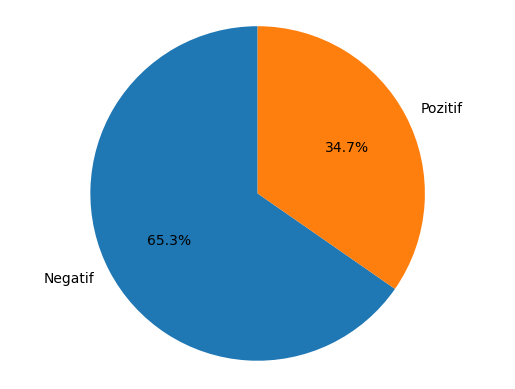

In [143]:
labels = BertData["BertTür"].map({"Pozitif":'Pozitif',"Negatif":'Negatif'}).value_counts().index.values
sizes = BertData["BertTür"].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,explode=None)
ax1.axis('equal')
plt.show()

<AxesSubplot:xlabel='BertTür', ylabel='count'>

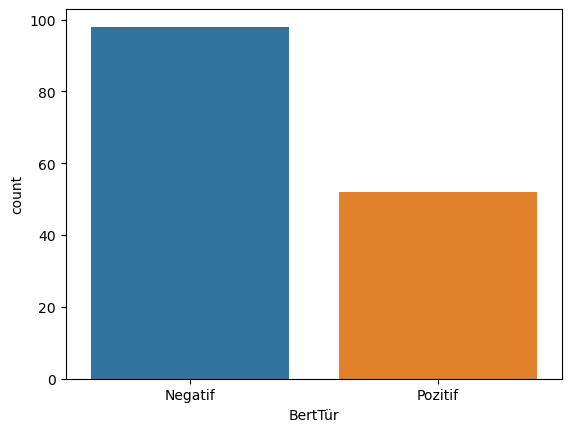

In [145]:
sns.countplot(BertData["BertTür"])

### ELECTRA (BERT MODEL TABANLI)

In [146]:
ElectraData=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','TextBlobTür','TextBlobYoğunluk','Tweet_Clear','Tweet_Eng'])
tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")

model = TFElectraForSequenceClassification.from_pretrained("bhadresh-savani/electra-base-emotion")

sentiment_result=[]
for text in tqdm(ElectraData["Tweet_Eng"]):
    inputs = tokenizer(text, return_tensors="tf")
    logits = model(**inputs).logits
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    result=model.config.id2label[predicted_class_id]
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([ElectraData,sentiment_result],axis=1)
tweets.to_csv("Datasets/Electra_Eng_Sonuc.csv",index=False)

ElectraData=pd.read_csv("Datasets/Electra_Eng_Sonuc.csv")
ElectraData.rename(columns={"0":"ElectraTür"}, inplace=True)
ElectraData["ElectraTür"]=ElectraData["ElectraTür"].map({"joy":'Mutlu',"anger":'Kızgın',"sadness":"Üzgün","fear":"Korku"})
ElectraData.head()


All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at bhadresh-savani/electra-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
100%|██████████| 150/150 [00:15<00:00,  9.45it/s]


,Tweet,Tweet_Clear,Tweet_Eng,Tür,Yoğunluk,ElectraTür
0,"Düşün şimdi: Tüm siyasi gündemi takip ediyorsun,futbol bilgin çok iyi. Borsadaki gelişmeler senden soruluyor. İşinde çok iyisin. Sosyal hayatın çok dolu. Dini meselelere bir türlü vakit bulamıyorsun. Sonra bir trafik kazası hoop ahirettesin. Ve hiçbir ilgin ve bilgin olmayan 👇",düşün şimdi tüm siyasi gündemi takip ediyorsun futbol bilgin çok iyi borsadaki gelişmeler senden soruluyor işinde çok iyisin sosyal hayatın çok dolu dini meselelere bir türlü vakit bulamıyorsun sonra bir trafik kazası hoop ahirettesin ve hiçbir ilgin ve bilgin olmayan,"think now you are following all the political agenda football bilgin very good stock market developments are being asked from you very good in your business, you can not find a time for a very full religious issues of social life, then a traffic accident is in the hereafter and no interest and no knowledge",Pozitif,%25 - %50,Mutlu
1,Ahh sıradaki futbol maçı ne zaman ne zaman? Şu kareler bile kalbini alıp götürüyor insanın. Karşıyaka Spor Kulübünün hastasıyız https://t.co/Y6qTpOyw0c,aah sıradaki futbol maçı ne zaman ne zaman şu kareler bile kalbini alıp götürüyor insanın karşıyaka spor kulübünün hastasıyız,"aah, the next football match when when even those squares take away the heart of the people of the people of karşıyaka sports club",Nötr,0 - 25%,Kızgın
2,"Milli Mücadele döneminde kurulduğu günden bu yana ilke ve kültürünü asla kaybetmeyen, her daim bilim,ahlak,felsefe şartlarıyla aydınlanmayı benimseyen, endüstriyel futbol dünyasında yerini alınmadan-satılmadan korumuş bir değer.\niyi ki doğdun soylu kavgam. \n#BüyükAltay109Yaşında",milli mücadele döneminde kurulduğu günden bu yana ilke ve kültürünü asla kaybetmeyen her daim bilim ahlak felsefe şartlarıyla aydınlanmayı benimseyen endüstriyel futbol dünyasında yerini alınmadan satılmadan korumuş bir değer iyi ki doğdun soylu kavgam,"since the day it was founded during the national struggle period, the principle and culture that has never lost its culture with the conditions of science, which has adopted the enlightenment with the conditions of moral philosophy, a value that has protected it without being sold in the world of football, is good that you were born.",Pozitif,%25 - %50,Üzgün
3,@bersankebikec Versinler futbol federasyonu başkanlığını oda kurtulsun bizde ...,versinler futbol federasyonu başkanlığını oda kurtulsun bizde,let them get the chairmanship of the football federation.,Nötr,0 - 25%,Mutlu
4,@serkan19_82 Futbol bu saha da oynamadan kağıt üzerindeki gibi neticelenmiyor malesef. :),futbol bu saha da oynamadan kağıt üzerindeki gibi neticelenmiyor maalesef,"football is not as on the paper without playing this field, unfortunately",Negatif,%75 - %100,Kızgın
5,@ahmetercanIar @Haluk_Yurekli @Haluk_Yurekli ve Gökhan dinç futbol teröristi ve provakatorlerdir. İnsanları kin ve düşmanlığa sevk etmekte üstlerine yoktur. Bu ikisi Türk futbolunun virusüsleridir. Kendilerine kufrettirip tazminat kovalayan iki kalitesizdir. Fotodaki gibi örnekleri de çoktur. https://t.co/JIOq4lQ7dm,ve gökhan dinç futbol teröristi ve provokatörlerdir insanları kin ve düşmanlığa sevk etmekte üstlerine yoktur bu ikisi türk futbolunun virüsüsleridir kendilerine küfrettirip tazminat kovalayan iki kalitesizdir fotodaki gibi örnekleri de çoktur,and gökhan dinç football terrorist and provocatetors are not in guidance and hostility.,Nötr,0 - 25%,Kızgın
6,futbol basketbolla aynı değil dostlar maçta ortalama 2 veya 3 gol oluyor her pozisyonun gol olmasını nasıl bekliyorsunuz anlamadım ki prime messi prime ronaldo da şunlardan bi sürü kaçırmıştır... önemli olan gol oranı yakaladığı net fırsatları bitirme oranı https://t.co/SQugUdVJKu,futbol basketbolla aynı değil dostlar maçta ortalama veya göl oluyor her pozisyonun gol olmasını nasıl bekliyorsunuz anlamadım ki prime messi prime ronaldo da şunlardan bir sürü kaçırmıştır önemli olan gol oranı yakaladığı net fırsatları bitirme oranı,football basketball is not the

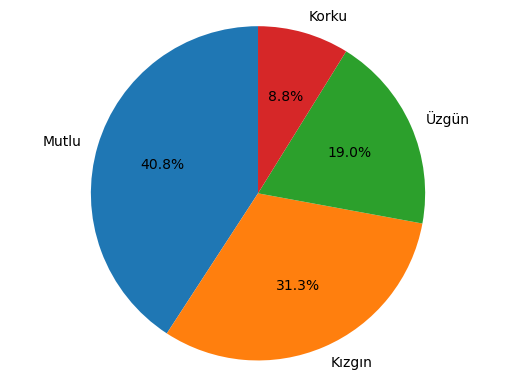

In [147]:
labels = ElectraData["ElectraTür"].map({"Mutlu":'Mutlu',"Kızgın":'Kızgın',"Üzgün":"Üzgün","Korku":"Korku"}).value_counts().index.values
sizes = ElectraData["ElectraTür"].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,explode=None)
ax1.axis('equal')
plt.show()

<AxesSubplot:xlabel='ElectraTür', ylabel='count'>

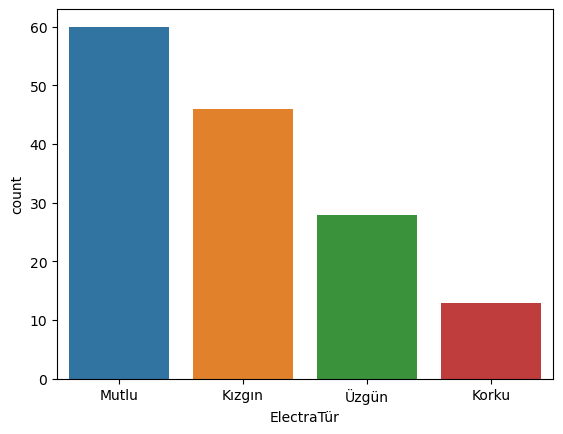

In [148]:
sns.countplot(ElectraData["ElectraTür"])

### Vader Sentiment

In [156]:
sid_obj= SentimentIntensityAnalyzer()
VaderData=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','TextBlobTür','TextBlobYoğunluk','Tweet_Clear','Tweet_Eng','Tweet_Ayrı_Eng'])
sentiment_result=[]
for text in tqdm(VaderData["Tweet_Ayrı_Eng"]):
    result = sid_obj.polarity_scores(text)
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([VaderData,sentiment_result],axis=1)
tweets.to_csv("Datasets/Vader_Tr_Sonuc.csv",index=False)
VaderData=pd.read_csv("Datasets/Vader_Tr_Sonuc.csv")
VaderData.rename(columns={"neg":"VaderNegatif",'neu':'VaderNötr','pos':'VaderPozitif','compound':'VaderYoğunluk'}, inplace=True)
VaderData.head()

100%|██████████| 150/150 [00:00<00:00, 13637.06it/s]


,Tweet,Tweet_Clear,Tweet_Eng,Tweet_Ayrı_Eng,Tür,Yoğunluk,Negatif,Nötr,Pozitif,VaderYoğunluk
0,"Düşün şimdi: Tüm siyasi gündemi takip ediyorsun,futbol bilgin çok iyi. Borsadaki gelişmeler senden soruluyor. İşinde çok iyisin. Sosyal hayatın çok dolu. Dini meselelere bir türlü vakit bulamıyorsun. Sonra bir trafik kazası hoop ahirettesin. Ve hiçbir ilgin ve bilgin olmayan 👇",düşün şimdi tüm siyasi gündemi takip ediyorsun futbol bilgin çok iyi borsadaki gelişmeler senden soruluyor işinde çok iyisin sosyal hayatın çok dolu dini meselelere bir türlü vakit bulamıyorsun sonra bir trafik kazası hoop ahirettesin ve hiçbir ilgin ve bilgin olmayan,"think now you are following all the political agenda football bilgin very good stock market developments are being asked from you very good in your business, you can not find a time for a very full religious issues of social life, then a traffic accident is in the hereafter and no interest and no knowledge","think following political agenda football bilgin good stock market developments asked good business, find time full religious issues social life, traffic accident hereafter interest knowledge",Pozitif,%25 - %50,0.094,0.638,0.267,0.6908
1,Ahh sıradaki futbol maçı ne zaman ne zaman? Şu kareler bile kalbini alıp götürüyor insanın. Karşıyaka Spor Kulübünün hastasıyız https://t.co/Y6qTpOyw0c,aah sıradaki futbol maçı ne zaman ne zaman şu kareler bile kalbini alıp götürüyor insanın karşıyaka spor kulübünün hastasıyız,"aah, the next football match when when even those squares take away the heart of the people of the people of karşıyaka sports club","aah, next football match even squares take away heart people people karşıyaka sports club",Nötr,0 - 25%,0.000,0.756,0.244,0.6369
2,"Milli Mücadele döneminde kurulduğu günden bu yana ilke ve kültürünü asla kaybetmeyen, her daim bilim,ahlak,felsefe şartlarıyla aydınlanmayı benimseyen, endüstriyel futbol dünyasında yerini alınmadan-satılmadan korumuş bir değer.\niyi ki doğdun soylu kavgam. \n#BüyükAltay109Yaşında",milli mücadele döneminde kurulduğu günden bu yana ilke ve kültürünü asla kaybetmeyen her daim bilim ahlak felsefe şartlarıyla aydınlanmayı benimseyen endüstriyel futbol dünyasında yerini alınmadan satılmadan korumuş bir değer iyi ki doğdun soylu kavgam,"since the day it was founded during the national struggle period, the principle and culture that has never lost its culture with the conditions of science, which has adopted the enlightenment with the conditions of moral philosophy, a value that has protected it without being sold in the world of football, is good that you were born.","since day founded national struggle period, principle culture never lost culture conditions science, adopted enlightenment conditions moral philosophy, value protected without sold world football, good born.",Pozitif,%25 - %50,0.069,0.628,0.304,0.7822
3,@bersankebikec Versinler futbol federasyonu başkanlığını oda kurtulsun bizde ...,versinler futbol federasyonu başkanlığını oda kurtulsun bizde,let them get the chairmanship of the football federation.,let get chairmanship football federation.,Nötr,0 - 25%,0.000,1.000,0.000,0.0000
4,@serkan19_82 Futbol bu saha da oynamadan kağıt üzerindeki gibi neticelenmiyor malesef. :),futbol bu saha da oynamadan kağıt üzerindeki gibi neticelenmiyor maalesef,"football is not as on the paper without playing this field, unfortunately","football paper without playing field, unfortunately",Negatif,%75 - %100,0.209,0.524,0.267,0.1139


### Model Karşılaştırılması

In [160]:
temp = pd.DataFrame()
tweets = pd.concat([ElectraData,BertData,VaderData],axis=1)
tweets.to_csv("Datasets/Duygu_Sonuc.csv",index=False)
temp=pd.read_csv('Datasets/Duygu_Sonuc.csv',usecols=['Tweet','Tweet_Celar','Tweet_Eng','TextBlobTür','TextBlobYoğunluk','ElectraTür','VaderPozitif','VaderNegatif','VaderNötr','BertTür','BertYoğunluk'])
temp.head()



ValueError: Usecols do not match columns, columns expected but not found: ['VaderNegatif', 'Tweet_Celar', 'TextBlobTür', 'VaderPozitif', 'VaderNötr', 'TextBlobYoğunluk']

### Son Model

In [150]:
Veri=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','Tür','Yoğunluk','Tweet_Clear','Tweet_Eng','Tweet_Ayrı_Eng'])
Veri["Tür"].value_counts()

Nötr       94
Pozitif    37
Negatif    19
Name: Tür, dtype: int64

<AxesSubplot:xlabel='Tür', ylabel='count'>

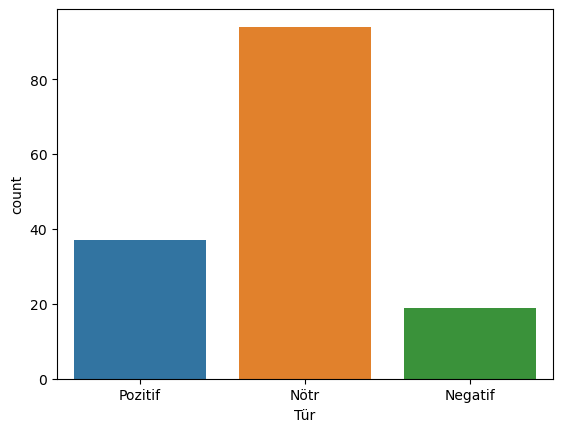

In [151]:
sns.countplot(Veri["Tür"])

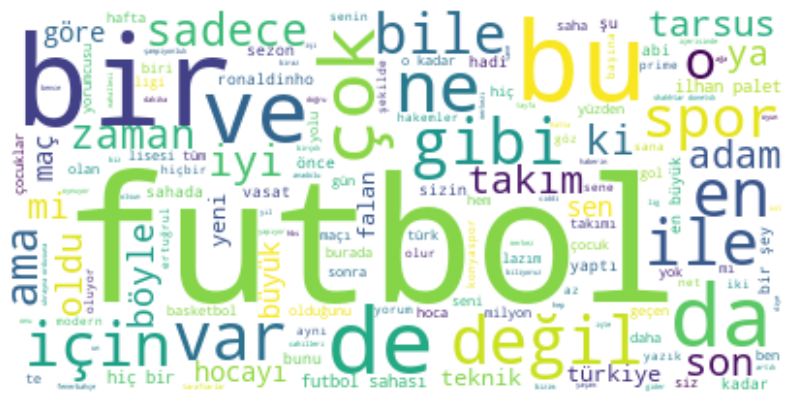

In [152]:
text = " ".join(review for review in Veri["Tweet_Clear"])
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [153]:
max_words = 500
max_len= 40

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', Veri['Tweet_Clear'][0])
X, tokenizer = tokenize_pad_sequences(Veri['Tweet_Clear'])
print('After Tokenization & Padding \n', X[0])



Before Tokenization & Padding 
 düşün şimdi tüm siyasi gündemi takip ediyorsun futbol bilgin çok iyi borsadaki gelişmeler senden soruluyor işinde çok iyisin sosyal hayatın çok dolu dini meselelere bir türlü vakit bulamıyorsun sonra bir trafik kazası hoop ahirettesin ve hiçbir ilgin ve bilgin olmayan
After Tokenization & Padding 
 [157 158  59 367 368 159 369   1 160   7  21 370 161 371 372 373   7 374
 162 163   7 375 376 164   2 377 378 379  60   2 380 381 382 383   5  92
 384   5 160 165]


In [135]:
vocab_size = tokenizer.document_count

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.LSTM(16, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          2400      
                                                                 
 lstm_3 (LSTM)               (None, 16)                2112      
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 4,563
Trainable params: 4,563
Non-trainable params: 0
_________________________________________________________________


In [136]:
y = pd.get_dummies(Veri['Tür'])
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.10, random_state=42)

print('Train Set ->', train_data.shape, train_label.shape)
print('Test Set ->', test_data.shape, test_label.shape)



Train Set -> (135, 40) (135, 3)
Test Set -> (15, 40) (15, 3)
